# Setup

In [97]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Char-RNN

## Splitting a sequence into batches of shuffled windows

In [98]:
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)

In [100]:
for index, (X_batch, Y_batch) in enumerate(dataset):
  print('_' * 20, 'Batch', index, '\nX_batch')
  print(X_batch.numpy())
  print('=' * 5, '\nY_batch')
  print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [101]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file('shakespeare.txt', shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

In [102]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [103]:
''.join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [104]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [105]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [106]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [107]:
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count

In [108]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])


In [109]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [110]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [111]:
np.random.seed(42)
tf.random.set_seed(42)

In [112]:
batch_size= 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [113]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [114]:
dataset = dataset.prefetch(1)

In [115]:
for X_batch, Y_batch in dataset.take(1):
  print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

In [116]:
model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
  keras.layers.GRU(128, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation='softmax'))
])

In [142]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
history = model.fit(dataset, steps_per_epoch=train_size // batch_size, epochs=1)

Train for 31370 steps
31370/31370 [==============================] - 468s 15ms/step - loss: 1.2022


## Using the Model to Generate Text

In [143]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

In [144]:
X_new = preprocess(['How are yo'])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

'u'

In [145]:
tf.random.set_seed(42)
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [146]:
def next_char(text, temperature=1):
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba)/temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [147]:
tf.random.set_seed(42)
next_char('How are yo', temperature=1)

'u'

In [148]:
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [149]:
tf.random.set_seed(42)
print(complete_text('t', temperature=0.2))

the words and look upon the sea:
and with the strai


In [150]:
print(complete_text('t', temperature=1))

to combined;
and through you arraves and sits as yo


In [151]:
print(complete_text('t', temperature=2))

tpeal memnly!--it?
coudunce begin! dear-urvir-banem


## Stateful RNN

In [152]:
tf.random.set_seed(42)

In [153]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [154]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
  dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
  dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_length))
  datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [155]:
model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2, recurrent_dropout=0.2, batch_input_shape=[batch_size, None, max_id]),
  keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2, recurrent_dropout=0.2),
  keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation='softmax'))
])

In [156]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [157]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
steps_per_epoch = train_size // batch_size // n_steps
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=1, callbacks=[ResetStatesCallback()])

Train for 313 steps
313/313 [==============================] - 103s 331ms/step - loss: 2.6192


In [158]:
stateless_model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
  keras.layers.GRU(128, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation='softmax'))
])

In [159]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [160]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [161]:
tf.random.set_seed(42)
print(complete_text('t'))

t! who doud whonoer this ve so my. beath h wonst
th


# Sentiment Analysis

In [162]:
tf.random.set_seed(42)

In [163]:
(X_train, y_train), (X_valid, y_valid) = keras.datasets.imdb.load_data()

In [164]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [166]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(('<pad>', '<sos>', '<unk>')):
  id_to_word[id_] = token
' '.join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [167]:
import tensorflow_datasets as tfds

datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /home/jupyter/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


In [168]:
datasets.keys()

dict_keys(['unsupervised', 'test', 'train'])

In [169]:
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

In [170]:
train_size, test_size

(25000, 25000)

In [171]:
for X_batch, y_batch in datasets['train'].batch(2).take(1):
  for review, label in zip(X_batch.numpy(), y_batch.numpy()):
    print('Review:', review.decode('utf-8')[:200], '...')
    print('Label:', label, '= Positive' if label else '= Negative')
    print()

Review: As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in ...
Label: 1 = Positive

Review: Oh yeah! Jenna Jameson did it again! Yeah Baby! This movie rocks. It was one of the 1st movies i saw of her. And i have to say i feel in love with her, she was great in this move.<br /><br />Her perfo ...
Label: 1 = Positive



In [174]:
def preprocess(X_batch, y_batch):
  X_batch = tf.strings.substr(X_batch, 0, 300)
  X_batch = tf.strings.regex_replace(X_batch, rb'<br\s*/?>', b' ')
  X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
  X_batch = tf.strings.split(X_batch)
  return X_batch.to_tensor(default_value=b'<pad>'), y_batch

In [175]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 60), dtype=string, numpy=
 array([[b'As', b'a', b'lifelong', b'fan', b'of', b'Dickens', b'I',
         b'have', b'invariably', b'been', b'disappointed', b'by',
         b'adaptations', b'of', b'his', b'novels', b'Although', b'his',
         b'works', b'presented', b'an', b'extremely', b'accurate', b're',
         b'telling', b'of', b'human', b'life', b'at', b'every', b'level',
         b'in', b'Victorian', b'Britain', b'throughout', b'them', b'all',
         b'was', b'a', b'pervasive', b'thread', b'of', b'humour', b'that',
         b'could', b'be', b'both', b'playful', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
        [b'Oh', b'yeah', b'Jenna', b'Jameson', b'did', b'it', b'again',
         b'Yeah', b'Baby', b'This', b'movie', b'rocks', b'It', b'was',
         b'one', b'of', b'the', b'st', b'movies', b'i', b'saw', b'of',
         b'her', b'And', b'i', b'have', b'to', b

In [176]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets['train'].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [177]:
vocabulary.most_common()[:3]

[(b'<pad>', 214869), (b'the', 61137), (b'a', 38564)]

In [178]:
len(vocabulary)

53893

In [179]:
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

In [180]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b'This movie was faaaaaantastic'.split():
  print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [181]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init =tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [182]:
table.lookup(tf.constant([b'This movie was faaaaaantastic'.split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [183]:
def encode_words(X_batch, y_batch):
  return table.lookup(X_batch), y_batch

In [184]:
train_set = datasets['train'].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [185]:
for X_batch, y_batch in train_set.take(1):
  print(X_batch)
  print(y_batch)

tf.Tensor(
[[  185     2 10865 ...     0     0     0]
 [  720  2431  5857 ...     0     0     0]
 [    6    98     9 ...     0     0     0]
 ...
 [  135     7    73 ...     0     0     0]
 [   22    12     7 ...     0     0     0]
 [10716   439   950 ...     0     0     0]], shape=(32, 66), dtype=int64)
tf.Tensor([1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0], shape=(32,), dtype=int64)


In [186]:
embed_size = 128
model = keras.models.Sequential([
  keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, mask_zero=True, input_shape=[None]),
  keras.layers.GRU(128, return_sequences=True),
  keras.layers.GRU(128),
  keras.layers.Dense(1, activation='sigmoid')
])

In [187]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 25s 33ms/step - loss: 0.5457 - accuracy: 0.7140
Epoch 2/5
781/781 [==============================] - 18s 23ms/step - loss: 0.3485 - accuracy: 0.8549
Epoch 3/5
781/781 [==============================] - 18s 23ms/step - loss: 0.1791 - accuracy: 0.9349
Epoch 4/5
781/781 [==============================] - 18s 23ms/step - loss: 0.1226 - accuracy: 0.9553
Epoch 5/5
781/781 [==============================] - 18s 23ms/step - loss: 0.1039 - accuracy: 0.9620


In [189]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation='sigmoid')(z)
model = keras.layers.Dense(1, activation='sigmoid')(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 24s 31ms/step - loss: 0.5429 - accuracy: 0.7180
Epoch 2/5
781/781 [==============================] - 18s 23ms/step - loss: 0.3471 - accuracy: 0.8592
Epoch 3/5
781/781 [==============================] - 19s 24ms/step - loss: 0.1932 - accuracy: 0.9326
Epoch 4/5
781/781 [==============================] - 18s 23ms/step - loss: 0.1237 - accuracy: 0.9567
Epoch 5/5
781/781 [==============================] - 18s 23ms/step - loss: 0.0935 - accuracy: 0.9679


## Reusing Pretrained Embeddings

In [190]:
tf.random.set_seed(42)

In [191]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, 'my_tfhub_cache')
os.environ['TFHUB_CACHE_DIR'] = TFHUB_CACHE_DIR

In [192]:
import tensorflow_hub as hub

model = keras.Sequential([
  hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1', dtype=tf.string, input_shape=[], output_shape=[50]),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

In [193]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [194]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
  for filename in filenames:
    print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [195]:
import tensorflow_datasets as tfds

In [196]:
datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

In [198]:
train_size = info.splits['train'].num_examples
batch_size = 32
train_set = datasets['train'].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 7s 9ms/step - loss: 0.5486 - accuracy: 0.7242
Epoch 2/5
781/781 [==============================] - 6s 8ms/step - loss: 0.5136 - accuracy: 0.7478
Epoch 3/5
781/781 [==============================] - 6s 8ms/step - loss: 0.5081 - accuracy: 0.7522
Epoch 4/5
781/781 [==============================] - 6s 8ms/step - loss: 0.5043 - accuracy: 0.7541
Epoch 5/5
781/781 [==============================] - 6s 8ms/step - loss: 0.5013 - accuracy: 0.7568


## Automatic Translation

In [199]:
tf.random.set_seed(42)

In [200]:
vocab_size = 100
embed_size = 10

In [202]:
import tensorflow_addons as tfa

In [203]:
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

In [204]:
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

In [205]:
encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

In [206]:
sampler = tfa.seq2seq.sampler.TrainingSampler()

In [208]:
decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

In [210]:
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths], outputs=[Y_proba])

In [211]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [212]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

In [213]:
history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Train on 1000 samples
Epoch 1/2
1000/1000 [==============================] - 5s 5ms/sample - loss: 4.6053
Epoch 2/2
1000/1000 [==============================] - 1s 1ms/sample - loss: 4.6031


### Bidirectional Recurrent Layers

In [214]:
model = keras.models.Sequential([
  keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
  keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

In [215]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_30 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [216]:
class PositionalEncoding(keras.layers.Layer):
  def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)
    if max_dims % 2 == 1: 
      max_dims += 1
    p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
    pos_emb = np.empty((1, max_steps, max_dims))
    pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
    pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
    self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
  def call(self, inputs):
    shape = tf.shape(inputs)
    return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [217]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

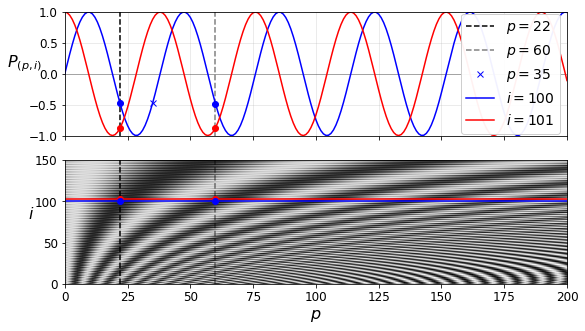

In [218]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], 'k--', label='$p = {}$'.format(p1))
ax1.plot([p2, p2], [-1, 1], 'k--', label='$p = {}$'.format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()


In [219]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

In [220]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

In [221]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [222]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])